In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [6]:
mol = Chem.MolFromSmiles("c1ccccc1")

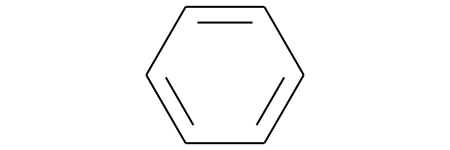

In [7]:
mol

In [14]:
mols = Chem.SDMolSupplier("/Users/keetane/Documents/Py4/ch05_compounds.sdf")

In [15]:
len(mols)

34

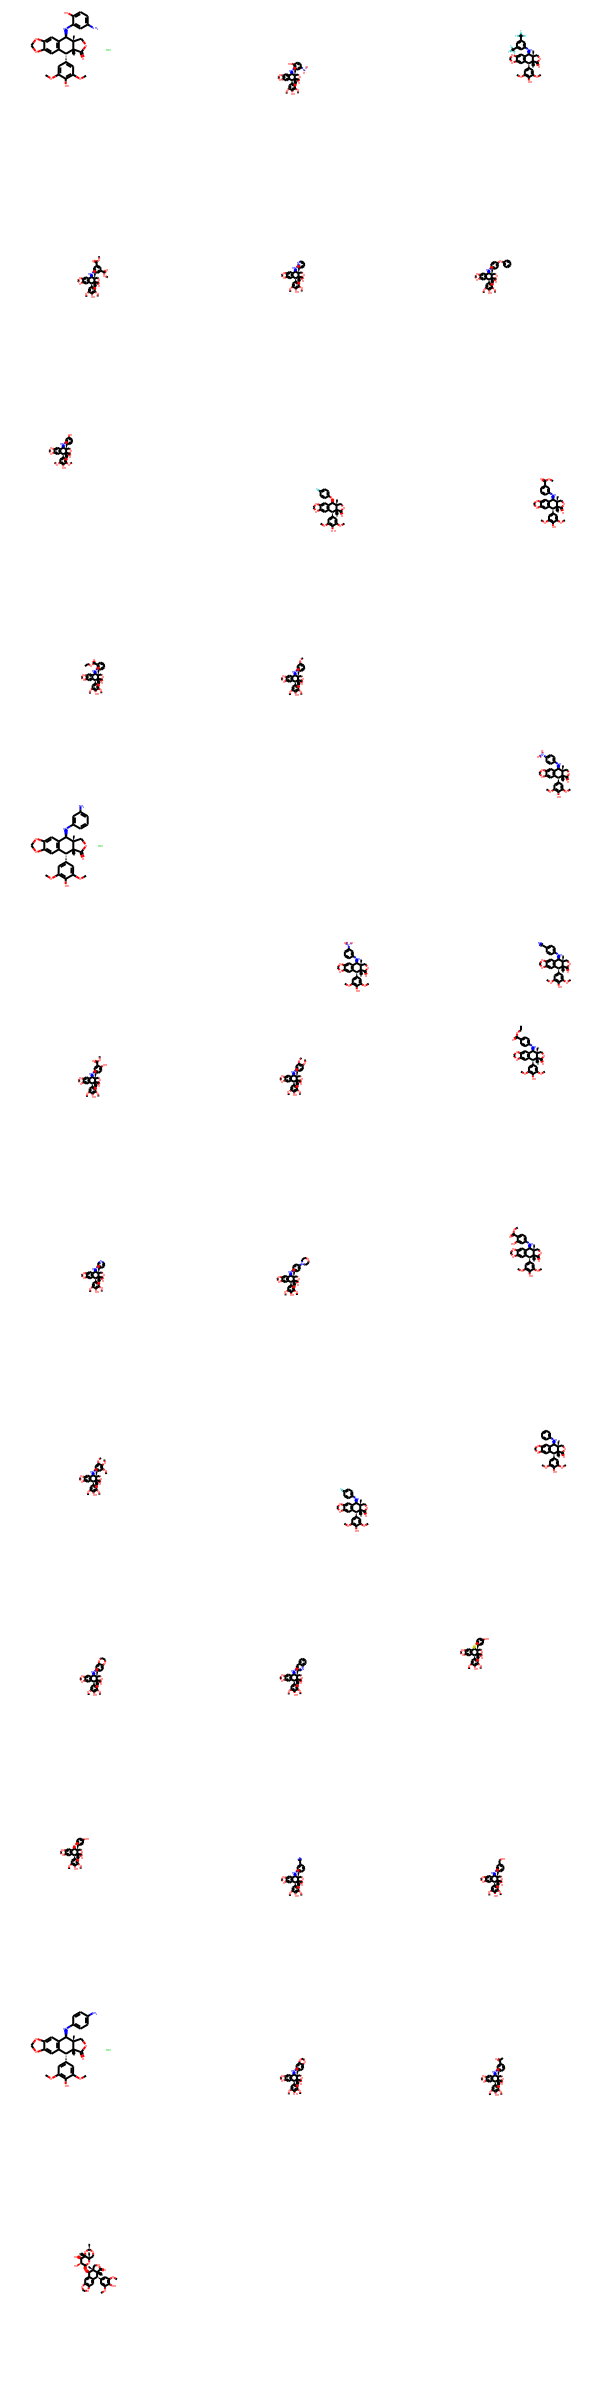

In [16]:
Draw.MolsToGridImage(mols)

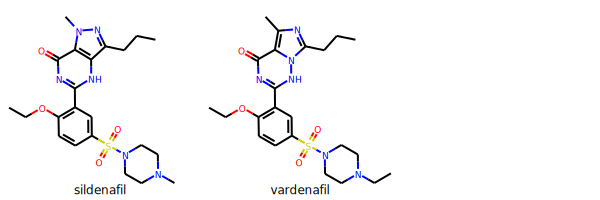

In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdFMCS
from rdkit.Chem import TemplateAlign
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
sildenafil = Chem.MolFromSmiles(
'CCCC1=NN(C)C2=C1NC(=NC2=O)C1=C(OCC)C=CC(=C1)S(=O)(=O)N1CCN(C)CC1')
vardenafil = Chem.MolFromSmiles(
'CCCC1=NC(C)=C2N1NC(=NC2=O)C1=C(OCC)C=CC(=C1)S(=O)(=O)N1CCN(CC)CC1')
rdDepictor.Compute2DCoords(sildenafil)
rdDepictor.Compute2DCoords(vardenafil)
res = rdFMCS.FindMCS([sildenafil, vardenafil], completeRingsOnly=True, atomCompare
=rdFMCS.AtomCompare.CompareAny)
MCS = Chem.MolFromSmarts(res.smartsString)
rdDepictor.Compute2DCoords(MCS)
TemplateAlign.AlignMolToTemplate2D(sildenafil, MCS)
TemplateAlign.AlignMolToTemplate2D(vardenafil, MCS)
Draw.MolsToGridImage([sildenafil, vardenafil], legends=['sildenafil', 'vardenafil'])

## HeteroShuffling

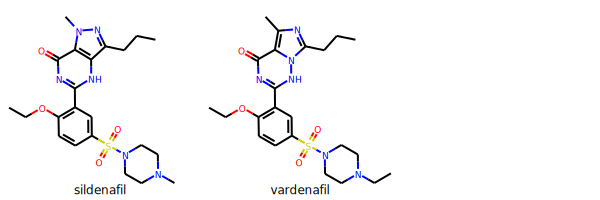

In [45]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdFMCS
from rdkit.Chem import TemplateAlign
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)

sildenafil = Chem.MolFromSmiles(
'CCCC1=NN(C)C2=C1NC(=NC2=O)C1=C(OCC)C=CC(=C1)S(=O)(=O)N1CCN(C)CC1')
vardenafil = Chem.MolFromSmiles(
'CCCC1=NC(C)=C2N1NC(=NC2=O)C1=C(OCC)C=CC(=C1)S(=O)(=O)N1CCN(CC)CC1')
rdDepictor.Compute2DCoords(sildenafil)
rdDepictor.Compute2DCoords(vardenafil)
res = rdFMCS.FindMCS([sildenafil, vardenafil], completeRingsOnly=True, atomCompare
=rdFMCS.AtomCompare.CompareAny)
MCS = Chem.MolFromSmarts(res.smartsString)
rdDepictor.Compute2DCoords(MCS)

TemplateAlign.AlignMolToTemplate2D(sildenafil, MCS)
TemplateAlign.AlignMolToTemplate2D(vardenafil, MCS)
Draw.MolsToGridImage([sildenafil, vardenafil], legends=['sildenafil', 'vardenafil'])

In [53]:
import copy
import itertools
from rdkit import Chem
from rdkit.Chem import AllChem
class HeteroShuffle():
    
    def __init__(self, mol, query):
        self.mol = mol
        self.query = query
        self.subs = Chem.ReplaceCore(self.mol, self.query)
        self.core = Chem.ReplaceSidechains(self.mol, self.query)
        self.target_atomic_nums = [6, 7, 8, 16]

    def make_connectors(self):
        n = len(Chem.MolToSmiles(self.subs).split('.'))
        map_no = n+1
        self.rxn_dict = {}
        for i in range(n):
            self.rxn_dict[i+1] = AllChem.ReactionFromSmarts(
'[{0}*][*:{1}].[{0}*][*:{2}]>>[*:{1}][*:{2}]'.format(i+1, map_no, map_no+1))
        return self.rxn_dict

    def re_construct_mol(self, core): 
        '''
        re construct mols from given substructures and core
        '''
        keys = self.rxn_dict.keys()
        ps = [[core]]
        for key in keys:
            ps = self.rxn_dict[key].RunReactants([ps[0][0], self.subs])
        mol = ps[0][0]
        try:
            smi = Chem.MolToSmiles(mol)
            mol = Chem.MolFromSmiles(smi)
            Chem.SanitizeMol(mol)
            return mol
        except:
            return None
 
    def get_target_atoms(self):
        '''
        get target atoms for replace
        target atoms means atoms which don't have anyatom(*) in neighbors
        '''
        atoms = []
        for atom in self.core.GetAromaticAtoms():
            neighbors = [a.GetSymbol() for a in atom.GetNeighbors()]
            if '*' not in neighbors and atom.GetSymbol() != '*':
                atoms.append(atom)
        print(len(atoms))
        return atoms
    
    def generate_mols(self):
        atoms = self.get_target_atoms()
        idxs = [atom.GetIdx() for atom in atoms]
        combinations = itertools.product(self.target_atomic_nums, repeat=len(idxs))
        smiles_set = set()
        self.make_connectors()
        for combination in combinations:
            target = copy.deepcopy(self.core)
            for i, idx in enumerate(idxs):
                target.GetAtomWithIdx(idx).SetAtomicNum(combination[i])
            smi = Chem.MolToSmiles(target)
            target = Chem.MolFromSmiles(smi)
            if target is not None:
                n_attachment = len([atom for atom in target.GetAtoms() if atom
.GetAtomicNum() == 0])
                n_aromatic_atoms = len(list(target.GetAromaticAtoms()))
                if target.GetNumAtoms() - n_attachment == n_aromatic_atoms:
                    try:
                        mol = self.re_construct_mol(target)
                        if check_mol(mol):
                            smiles_set.add(Chem.MolToSmiles(mol))
                    except:
                        pass
        mols = [Chem.MolFromSmiles(smi) for smi in smiles_set]
        return mols
    
    def check_mol(mol):
        arom_atoms = mol.GetAromaticAtoms()
        symbols = [atom.GetSymbol() for atom in arom_atoms if not atom.IsInRingSize(5)]
        if not symbols:
            return True
        elif 'O' in symbols or 'S' in symbols:
            return False
        else:
            return True

In [55]:
# Gefitinib
mol1 = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
core1 = Chem.MolFromSmiles('c1ccc2c(c1)cncn2')
  #  Oxaprozin
mol2 = Chem.MolFromSmiles('OC(=O)CCC1=NC(=C(O1)C1=CC=CC=C1)C1=CC=CC=C1')
core2 = Chem.MolFromSmiles('c1cnco1')

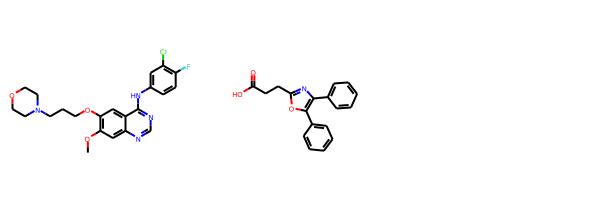

In [56]:
Draw.MolsToGridImage([mol1,mol2])

7


RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:

RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Ca

RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR

RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:

RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized ato

RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkek

RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 8 11
RDKit ERROR: 
RDKit ERROR: [23:38:25] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7

RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:25] Explicit valence for atom # 9 

RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize

RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:26] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 11
RDKit

RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 

RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 

RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:26] Explicit valence for atom # 3 

RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] 

RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can'

RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11

RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:27] Can't 

RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can'

RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Ca

RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 

RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 9 10 11
RDKit ERROR: 
RDKit ER

RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:28] Can't kekulize mol

RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 10 11


RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 9 

RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized atoms: 1 2 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:29] Can't kekulize mol.  Unkekulized

RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 

RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:29] Explicit valence for atom # 3 

RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 3 

RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 10 11
RDKit ERROR: 
RDKit 

RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekuliz

RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:30] Explicit valence for atom # 9 

RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:30] Can't kekulize

RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 9 11
RDKit ERROR

RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 

RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:31] Explicit valence for atom # 9 

RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:31] Can't kekulize mol

RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 

RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 10 11
RDKit 

RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:32] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:32] Explicit va

RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 

RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 6 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Can't kekulize mol.  Unkekulized atoms: 1 4 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:32] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:32] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:3

RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 

RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 

RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:33] Explicit valence for atom # 3 

RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 

RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:33] Can't kekulize mol.  U

RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:34] Explicit valence for atom # 9 

RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] 

RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  U

RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:34] Can't kekulize

RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:35] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:35] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:35] Explic

RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] 

RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 

RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:35] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 8 10

RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 9 O,

RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 6 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekulized atoms: 1 4 6 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:36] Can't kekulize mol.  Unkekuliz

RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 

RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 

RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:36] Explicit valence for atom # 3 

RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 3 

RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 8 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 

RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 8 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized a

RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 O, 5, is greater than permitted
RDKit ERROR: [23:38:37] Explicit valence for atom # 9 

RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 6 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  Unkekulized atoms: 1 3 4 7 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:38:37] Can't kekulize mol.  U

32


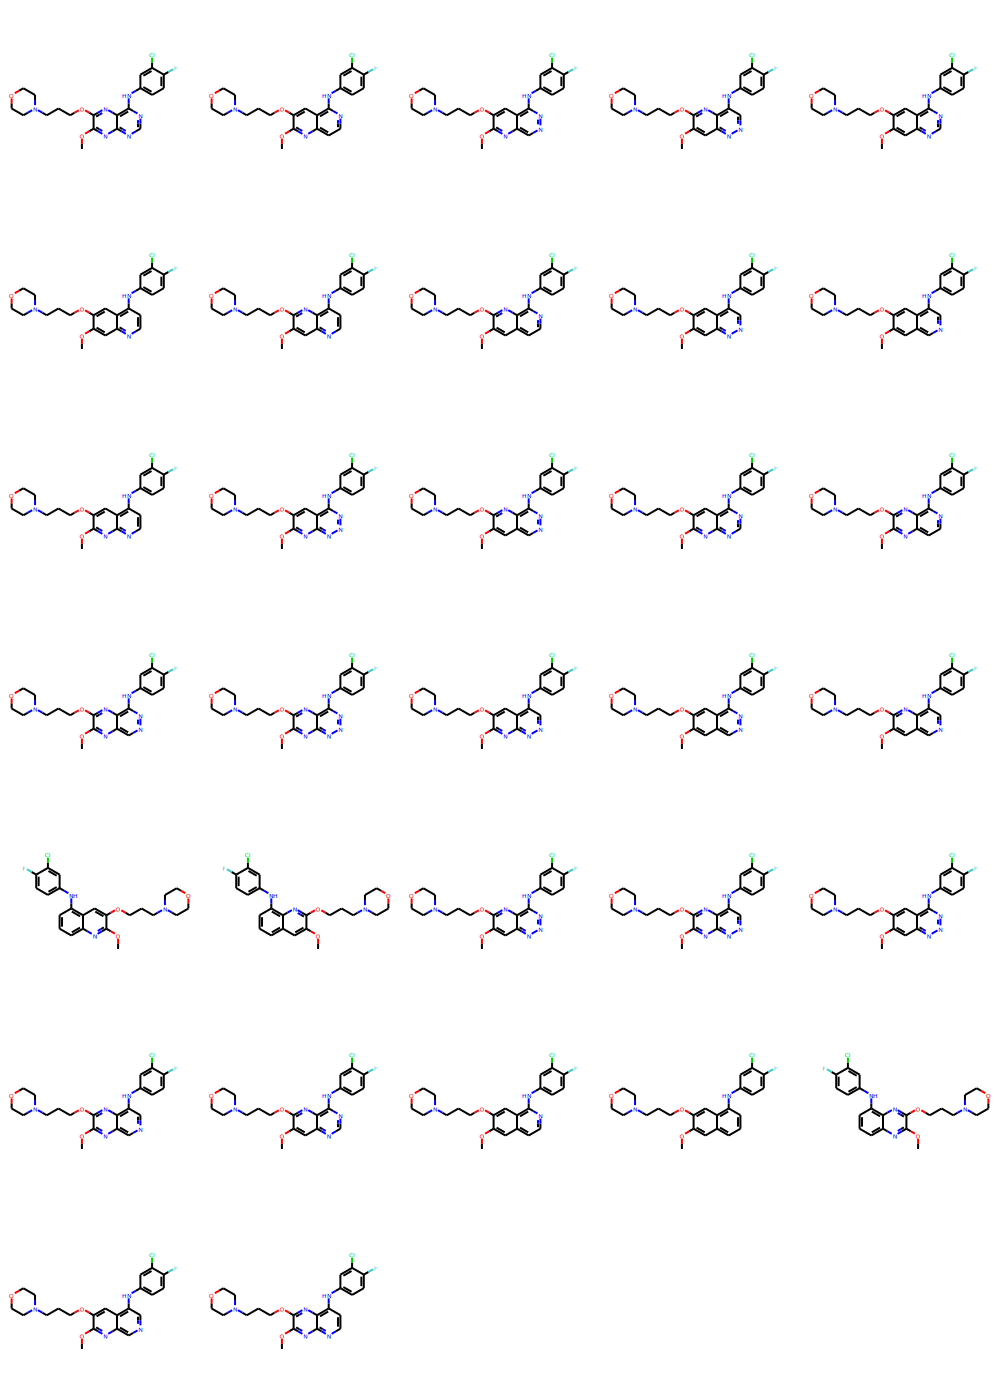

In [58]:
ht = HeteroShuffle(mol1, core1)
res = ht.generate_mols()
print(len(res))
Draw.MolsToGridImage(res, molsPerRow=5)

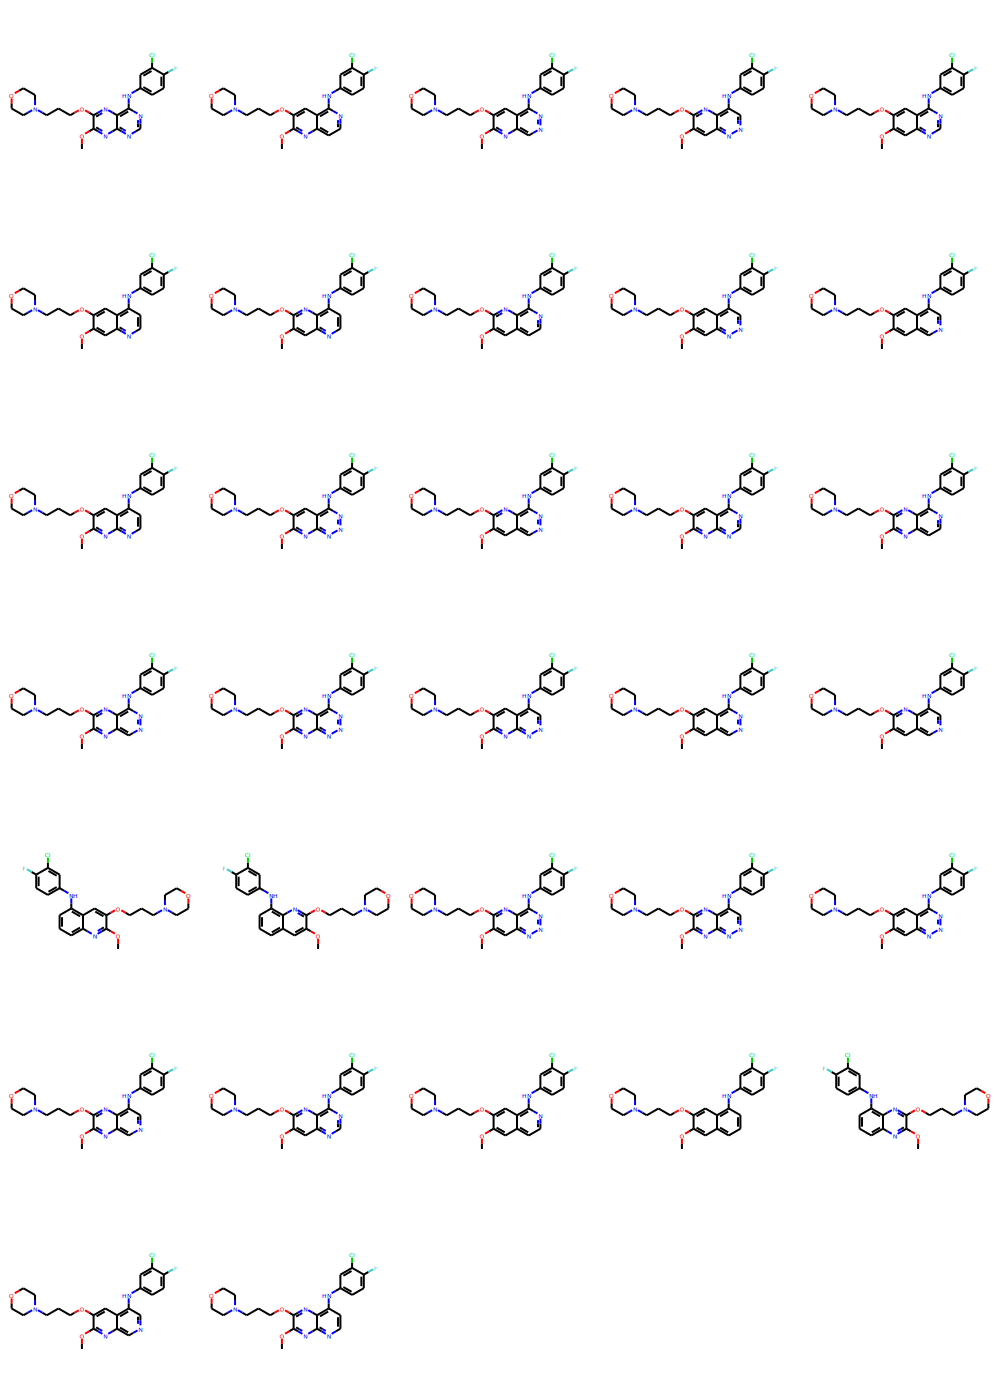

In [59]:
Draw.MolsToGridImage(res, molsPerRow=5)

2
4


RDKit ERROR: [23:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
RDKit ERROR: 
RDKit ERROR: [23:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
RDKit ERROR: 
RDKit ERROR: [23:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
RDKit ERROR: 
RDKit ERROR: [23:39:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6
RDKit ERROR: 
RDKit ERROR: [23:39:46] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [23:39:46] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [23:39:47] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [23:39:47] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 


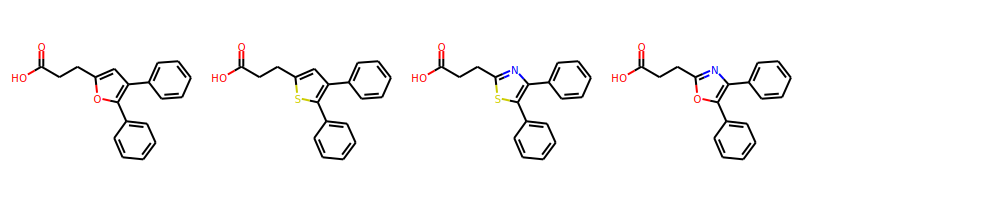

In [60]:
ht = HeteroShuffle(mol2, core2)
res = ht.generate_mols()
print(len(res))
Draw.MolsToGridImage(res, molsPerRow=5)

# 類似度計算

In [61]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

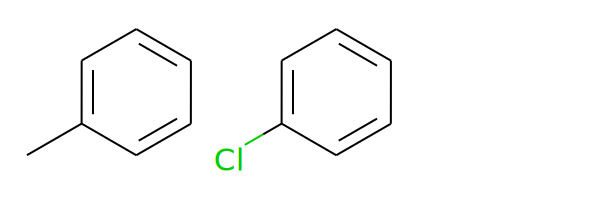

In [62]:
mol1 = Chem.MolFromSmiles("Cc1ccccc1")
mol2 = Chem.MolFromSmiles("Clc1ccccc1")
Draw.MolsToGridImage([mol1, mol2])

In [65]:
fp1 = AllChem.GetMorganFingerprint(mol1, 2)
fp2 = AllChem.GetMorganFingerprint(mol2, 2)
DataStructs.TanimotoSimilarity(fp1, fp2)
# 0.5384615384615384

0.5384615384615384

In [66]:
DataStructs.TanimotoSimilarity(fp1, fp2, returnDistance=True)
# 0.46153846153846156

0.46153846153846156

# Virtual Screening
### wgetできない

In [67]:
!wget http://files.docking.org/2D/EA/EAED.smi

/bin/bash: wget: command not found


In [68]:
spl = Chem.rdmolfiles.SmilesMolSupplier("EAED.smi")
len(spl)
# 195493

OSError: File error: Bad input file EAED.smi

In [69]:
laninamivir = Chem.MolFromSmiles(
"CO[C@H]([C@H](O)CO)[C@@H]1OC(=C[C@H](NC(=N)N)[C@H]1NC(=O)C)C(=O)O")
laninamivir_fp = AllChem.GetMorganFingerprint(laninamivir, 2)
def calc_laninamivir_similarity(mol):
    fp = AllChem.GetMorganFingerprint(mol, 2)
    sim = DataStructs.TanimotoSimilarity(laninamivir_fp, fp)
    return sim

In [70]:
similar_mols = []
for mol in spl:
    sim = calc_laninamivir_similarity(mol)
    if sim > 0.2:
        similar_mols.append((mol, sim))

NameError: name 'spl' is not defined

# クラスタリング